## Data

In [43]:
import os
import requests
import time
import zipfile
import shutil
from tqdm import tqdm
import json

import sqlite3
import pandas as pd



In [14]:
KAGGLE_JSON_PATH = "kaggle.json" 
from kaggle.api.kaggle_api_extended import KaggleApi


In [44]:
DATA_DIR = "data"
FULL_DATA_DIR = os.path.join(DATA_DIR, "full-data")


In [12]:
import warnings
warnings.filterwarnings("ignore")

### Downloading and cleaning initial data files

Data source: https://github.com/Zdong104/FNSPID_Financial_News_Dataset

#### News & Stock Market Data

In [ ]:


def download_files(urls):
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    for url in urls:
        filename = os.path.basename(url)
        filepath = os.path.join(FULL_DATA_DIR, filename)
        start_time = time.time()

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))

        if response.status_code == 200:
            with open(filepath, "wb") as f, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=f"Downloading {filename}"
            ) as progress_bar:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
                    progress_bar.update(len(chunk))

            elapsed_time = time.time() - start_time
            print(f"✅ Downloaded: {filepath} in {elapsed_time:.2f} seconds")

            if filename.endswith(".zip"):
                extract_zip(filepath)

        else:
            print(f"❌ Failed to download: {url}")

def extract_zip(zip_path):
    if os.path.exists(zip_path):
        print(f"📦 Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(FULL_DATA_DIR)
        print(f"✅ Extracted to {FULL_DATA_DIR}")

        clean_unwanted_files(FULL_DATA_DIR)
        os.remove(zip_path)
        print(f"🗑️ Deleted ZIP file: {zip_path}")

def clean_unwanted_files(directory):
    macosx_path = os.path.join(directory, "__MACOSX")
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print(f"🗑️ Removed: {macosx_path}")

urls = [
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_price/full_history.zip",
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/nasdaq_exteral_data.csv"
]

download_files(urls)


✅ Downloaded: data/full-data/full_history.zip in 11.35 seconds
📦 Extracting data/full-data/full_history.zip...
✅ Extracted to data/full-data
🗑️ Removed: data/full-data/__MACOSX
🗑️ Deleted ZIP file: data/full-data/full_history.zip


✅ Downloaded: data/full-data/nasdaq_exteral_data.csv in 459.38 seconds


#### Bitcoin Historical Data

Data source: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [ ]:
def setup_kaggle_credentials(json_path):
    """Load and set Kaggle credentials from a local JSON file."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"❌ Kaggle credentials file not found at {json_path}")

    with open(json_path, "r") as f:
        creds = json.load(f)

    os.environ["KAGGLE_USERNAME"] = creds["username"]
    os.environ["KAGGLE_KEY"] = creds["key"]
    print("Kaggle API credentials set up successfully!")

def download_kaggle_dataset(dataset):
    """Download and extract the dataset from Kaggle."""
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    setup_kaggle_credentials(KAGGLE_JSON_PATH)

    api = KaggleApi()
    api.authenticate()

    print(f"Downloading {dataset} from Kaggle...")
    api.dataset_download_files(dataset, path=FULL_DATA_DIR, unzip=True)
    print(f"✅ Downloaded and extracted: {dataset}")

    clean_unwanted_files(FULL_DATA_DIR)

download_kaggle_dataset("mczielinski/bitcoin-historical-data")


Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
✅ Downloaded and extracted: mczielinski/bitcoin-historical-data


This dataset contains historical Bitcoin price data recorded at one-minute intervals. The main file included is:
- `btcusd_1-min_data.csv`: Contains one-minute price data for Bitcoin, including Open, High, Low, Close (OHLC) prices, volume, and timestamp information.

#### ETH

Source: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset

In [42]:
download_kaggle_dataset("prasoonkottarathil/ethereum-historical-dataset")


Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
✅ Downloaded and extracted: prasoonkottarathil/ethereum-historical-dataset


This dataset provides a collection of Ethereum price data at different time intervals, making it useful for market analysis and trading strategies. It includes three CSV files:

- `ETH_1H.csv`: Contains hourly Ethereum price data, including OHLC prices and volume.
- `ETH_1min.csv`: Contains one-minute Ethereum price data, similar to Bitcoin's dataset.
- `ETH_day.csv`: Contains daily Ethereum price data.

We could not load all the data, so we decided to create a DB from which we could pull the csv with chunks and then lated use pandas.

In [30]:
import os
import sqlite3
import pandas as pd

# Construct file paths using FULL_DATA_DIR
csv_file = os.path.join(FULL_DATA_DIR, "nasdaq_exteral_data.csv")
db_file = os.path.join(FULL_DATA_DIR, "news_data.db")
raw_table = "news_data"  # Table name variable

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect(db_file)

chunksize = 100000  
total_rows = 0
chunk_count = 0

# Define the columns you want to keep
columns_to_keep = ["Date", "Article_title", "Stock_symbol"]

# Read and insert CSV data in chunks, keeping only the specified columns
for chunk in pd.read_csv(csv_file, chunksize=chunksize):
    # Select only the desired columns
    chunk = chunk[columns_to_keep]
    rows_in_chunk = len(chunk)
    chunk.to_sql(raw_table, conn, if_exists="append", index=False)
    chunk_count += 1
    total_rows += rows_in_chunk

# Create an index on the "Date" column after inserting all data
cursor = conn.cursor()
cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_date ON {raw_table}(Date)")
conn.commit()

print(f"Database creation complete. Total rows inserted: {total_rows} across {chunk_count} chunks.")


Database creation complete. Total rows inserted: 15549299 across 156 chunks.


In [32]:
agg_table = "aggregated_news_data"
raw_table = "news_data"

# Load the raw table into a pandas DataFrame
df_raw = pd.read_sql_query(f"SELECT * FROM {raw_table}", conn)


In [ ]:
conn.close()

In [ ]:
# Drop rows where 'Date' or 'Article_title' is NaN
df_raw = df_raw.dropna(subset=['Date', 'Article_title'])

In [34]:

# Group by Date and Article_title, aggregating Stock_symbol values.
# The lambda function drops NaNs and duplicates, then converts values to string before joining.
df_agg = df_raw.groupby(['Date', 'Article_title'], as_index=False).agg(
    Stock_symbols=('Stock_symbol', lambda x: ",".join(x.dropna().drop_duplicates().astype(str)))
)

# Display results
row_count = len(df_agg)
print(f"Aggregated DataFrame row count: {row_count}")
print(df_agg.head())

Aggregated DataFrame row count: 12480047
                      Date                                      Article_title  \
0  1914-09-16 00:00:00 UTC  1914. Празднование столетия М.Ю. Лермонтова от...   
1  1914-09-16 00:00:00 UTC  1914. Русские войска вступили в пределы Венгрии     
2  1914-09-17 00:00:00 UTC                           1914. Das ist Nesteroff!   
3  1914-09-17 00:00:00 UTC                    1914. Бульдог-гонец под Льежем    
4  1914-09-18 00:00:00 UTC           1914. Под Люблином пойман швабский зверь   

  Stock_symbols  
0                
1                
2                
3                
4                


In [39]:
PROCESSED_DATA = os.path.join(DATA_DIR, "processed-data")
NEWS_CSV = os.path.join(PROCESSED_DATA, "aggregated-news.csv.gz")

# Ensure the processed data directory exists
os.makedirs(PROCESSED_DATA, exist_ok=True)

We initially stored the data as a CSV, which resulted in a file size of 1.3 GB. While this isn't enormous, it's still too large for our repository. After compressing with `gzip`, the file size dropped to 383.3 MB.

In [40]:
df_agg.to_csv(NEWS_CSV, compression="gzip", index=False)

#### Load Full Data


In [41]:
df_agg = pd.read_csv(NEWS_CSV, compression="gzip")

We will be processing this to only include the years needed for our analysis. 

#### Importing coin data

We store coin data files as a safeguard so that if any issues arise, we can quickly re-import the data rather than re-running the entire analysis.

In [61]:
btc_file = os.path.join(FULL_DATA_DIR, "btcusd_1-min_data.csv")
btc_df = pd.read_csv(btc_file)

# Convert the numeric Timestamp (in seconds) to UTC datetime and format as "YYYY-MM-DD HH:MM:SS UTC"
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"].astype(float), unit="s", utc=True)
btc_df["Date"] = btc_df["Date"].dt.strftime("%Y-%m-%d %H:%M:%S UTC")

btc_df = btc_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
btc_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00 UTC,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00 UTC,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00 UTC,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00 UTC,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00 UTC,4.58,4.58,4.58,4.58,0.0


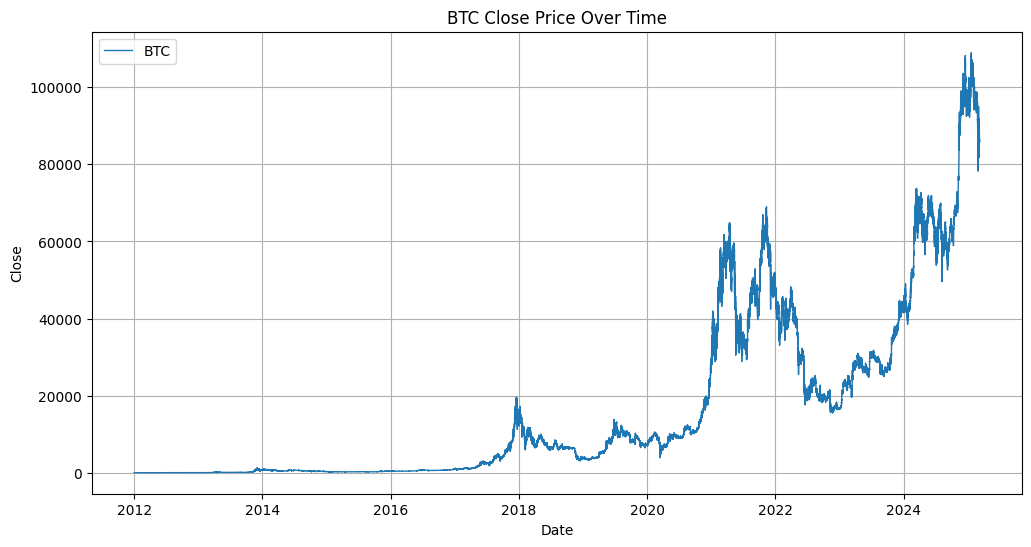

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    """
    Plots the crypto price data over time.
    
    Parameters:
        df (pd.DataFrame): DataFrame with a date column and a price column.
        coin_name (str): The name of the crypto (used for the plot title and label).
        date_col (str): The column name in df that contains date information.
        price_col (str): The column name in df that contains the price data.
    """
    # Convert the date column to datetime, coerce errors, and drop invalid dates
    df["Date_dt"] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=["Date_dt"])
    
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date_dt"], df[price_col], label=coin_name, linewidth=1)
    plt.xlabel("Date")
    plt.ylabel(price_col)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with BTC data:
plot_crypto_data(btc_df, coin_name="BTC")


In [62]:
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
btc_df.to_csv(btc_processed_file, index=False, compression="gzip")

In [76]:
eth_file = os.path.join(FULL_DATA_DIR, "ETH_1min.csv")
eth_df = pd.read_csv(eth_file)
eth_df = eth_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
eth_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-16 00:00:00,152.94,152.94,151.33,151.33,112.724931
1,2020-04-15 23:59:00,152.94,152.94,152.94,152.94,0.000000
2,2020-04-15 23:58:00,153.17,153.17,152.94,152.94,0.013011
3,2020-04-15 23:57:00,152.96,153.20,152.96,153.17,466.782278
4,2020-04-15 23:56:00,153.14,153.14,152.96,152.96,167.930714


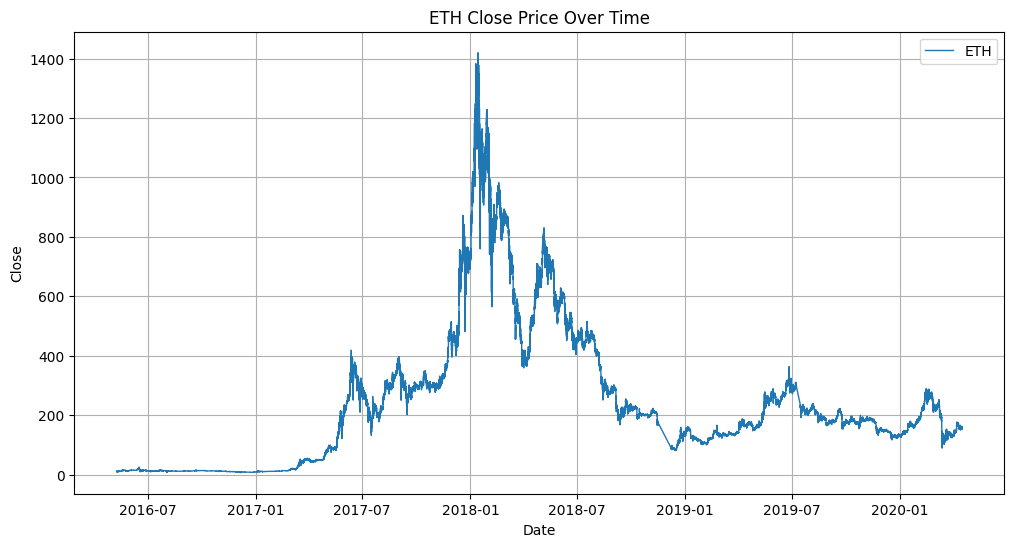

In [77]:
plot_crypto_data(eth_df, coin_name="ETH")

In [78]:
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
eth_df.to_csv(eth_processed_file, index=False, compression="gzip")

In [ ]:
crypto_df = pd.concat([btc_df, eth_df], ignore_index=True)

In [85]:
# Convert the "Date" column to datetime objects (with UTC)
crypto_df["Date"] = pd.to_datetime(crypto_df["Date"], errors="coerce", utc=True)

# Now compute the min and max dates
start_date = crypto_df["Date"].min()
end_date = crypto_df["Date"].max()
print(f"Combined crypto data range: {start_date} to {end_date}")


Combined crypto data range: 2012-01-01 10:01:00+00:00 to 2025-03-09 00:00:00+00:00


In [86]:
# Save the combined DataFrame as a compressed CSV
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
crypto_df.to_csv(combined_file, index=False, compression="gzip")

In [87]:
# Convert the 'Date' column in df_agg to datetime objects with UTC timezone
df_agg["Date_dt"] = pd.to_datetime(df_agg["Date"], errors="coerce", utc=True)

# Filter the DataFrame to include only rows between start_date and end_date
df_filtered_news = df_agg[(df_agg["Date_dt"] >= start_date) & (df_agg["Date_dt"] <= end_date)]

print(f"Filtered news count: {len(df_filtered_news)}")

Filtered news count: 7210953


In [88]:
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
df_filtered_news.to_csv(NEWS_FILTERED_CSV, compression="gzip", index=False)

## `breakpoint`


You can run this to import all of the files in. Make sure to download the data from hugging face.

In [89]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")
